In [8]:
import os
import pyspark
from pyspark.sql import SQLContext, SparkSession
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer
import findspark
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold  
import pandas as pd
import re, string
from pyspark.ml.feature import Word2Vec
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import rand 
from pyspark.ml.linalg import DenseVector
from pyspark.ml.feature import VectorAssembler

findspark.init()
findspark.find()

spark = SparkSession \
        .builder \
        .appName("sparkFromJupyter") \
        .getOrCreate()
 

 
print("Spark Version: " + spark.version)
print("PySpark Version: " + pyspark.__version__) 

Spark Version: 3.3.1
PySpark Version: 3.3.1


In [2]:
CATEGORIES = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [3]:
train_data = pd.read_csv("train.csv")
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Генерирую колонки с фичами HashingTF+IDF

In [23]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import IDF
 

train_data_spark = spark.createDataFrame(train_data) 
tokenizer = Tokenizer(inputCol="comment_text", outputCol="tkn") 
train_data_spark = tokenizer.transform(train_data_spark)
features_list = [x for x in range(200, 1200, 200)]
for n_features in features_list:
    print(n_features)
    hashingTF = HashingTF(inputCol="tkn", outputCol=f"raw_hdf_{n_features}", numFeatures=n_features )
    #idf = IDF( outputCol='features')
    idf = IDF(inputCol=f'raw_hdf_{n_features}', outputCol=f"HTFfeatures_idf_{n_features}")
    pipeline = Pipeline(stages=[hashingTF, idf])
    model = pipeline.fit(train_data_spark)
    train_data_spark = model.transform(train_data_spark)
    print('done')

200
done
400
done
600
done
800
done
1000
done


Обучение классификатора

In [26]:


res_idf = []
evaluator = BinaryClassificationEvaluator()
for n_features in features_list:
    for cat in CATEGORIES:
        cat_subset = train_data_spark[[f"HTFfeatures_idf_{n_features}", cat]]\
        .withColumnRenamed(cat,'label')\
        .withColumnRenamed(f"HTFfeatures_idf_{n_features}",'features') 

        lr_notuning = LogisticRegression(maxIter=10, regParam=0.1)
        grid = ParamGridBuilder().addGrid(lr_notuning.maxIter, [10]).build()
        cv = CrossValidator(estimator=lr_notuning, estimatorParamMaps=grid, evaluator=evaluator,
                parallelism=8,numFolds=3)
        cvModel = cv.fit(cat_subset)
        prediction_cv = cvModel.transform(cat_subset)
        output_cv = evaluator.evaluate(prediction_cv)
        #print(notuning_output) 


        print(f'n_features = {n_features} category: {cat}  score={output_cv}')
        res_idf.append([n_features, cat, output_cv]) 

n_features = 200 category: toxic  score=0.7893430254112509
n_features = 200 category: severe_toxic  score=0.8829838622366031
n_features = 200 category: obscene  score=0.7998739965947125
n_features = 200 category: threat  score=0.8417135136899349
n_features = 200 category: insult  score=0.8012387446488353
n_features = 200 category: identity_hate  score=0.753231286846114
n_features = 400 category: toxic  score=0.8144573862840935
n_features = 400 category: severe_toxic  score=0.9003804335661157
n_features = 400 category: obscene  score=0.8246165934892536
n_features = 400 category: threat  score=0.8712130614269009
n_features = 400 category: insult  score=0.8292484196823549
n_features = 400 category: identity_hate  score=0.791113123051987
n_features = 600 category: toxic  score=0.8329078897884793
n_features = 600 category: severe_toxic  score=0.9079160966952958
n_features = 600 category: obscene  score=0.8448780719147669
n_features = 600 category: threat  score=0.8958250045426179
n_features

Генерирую колонки с фичами w2v

In [4]:
from pyspark.ml.feature import Word2Vec
train_data_spark = spark.createDataFrame(train_data) 
tokenizer = Tokenizer(inputCol="comment_text", outputCol="tkn") 
train_data_spark = tokenizer.transform(train_data_spark)
features_list = [x for x in range(2, 12, 2)]
for n_features in features_list:
    print(n_features)
    word2Vec = Word2Vec(vectorSize=n_features, minCount=10, inputCol='tkn', outputCol=f'w2v_{n_features}')
    model = word2Vec.fit(train_data_spark)

    train_data_spark = model.transform(train_data_spark)

2
4
6
8
10


Обучаею классификатор

In [9]:
res_w2v = []
evaluator = BinaryClassificationEvaluator()
for n_features in features_list:
    for cat in CATEGORIES:
        cat_subset = train_data_spark[[f"w2v_{n_features}", cat]]\
        .withColumnRenamed(cat,'label')\
        .withColumnRenamed(f"w2v_{n_features}",'features') 

        lr_notuning = LogisticRegression(maxIter=10, regParam=0.1)
        grid = ParamGridBuilder().addGrid(lr_notuning.maxIter, [10]).build()
        cv = CrossValidator(estimator=lr_notuning, estimatorParamMaps=grid, evaluator=evaluator,
                parallelism=8,numFolds=3)
        cvModel = cv.fit(cat_subset)
        prediction_cv = cvModel.transform(cat_subset)
        output_cv = evaluator.evaluate(prediction_cv)
        #print(notuning_output) 


        print(f'n_features = {n_features} category: {cat}  score={output_cv}')
        res_w2v.append([n_features, cat, output_cv]) 

n_features = 2 category: toxic  score=0.7257525424597007
n_features = 2 category: severe_toxic  score=0.8876453655195908
n_features = 2 category: obscene  score=0.7925059925254971
n_features = 2 category: threat  score=0.8071991561894524
n_features = 2 category: insult  score=0.7773847252670704
n_features = 2 category: identity_hate  score=0.7364636316374306
n_features = 4 category: toxic  score=0.8421723091875218
n_features = 4 category: severe_toxic  score=0.9316326173429303
n_features = 4 category: obscene  score=0.8750727397274093
n_features = 4 category: threat  score=0.8798585664493973
n_features = 4 category: insult  score=0.871251626833082
n_features = 4 category: identity_hate  score=0.881178954603441
n_features = 6 category: toxic  score=0.8923070458020469
n_features = 6 category: severe_toxic  score=0.9664459844938151
n_features = 6 category: obscene  score=0.9196271564399556
n_features = 6 category: threat  score=0.9251103608328669
n_features = 6 category: insult  score=0.9

In [25]:
import matplotlib.pyplot as plt


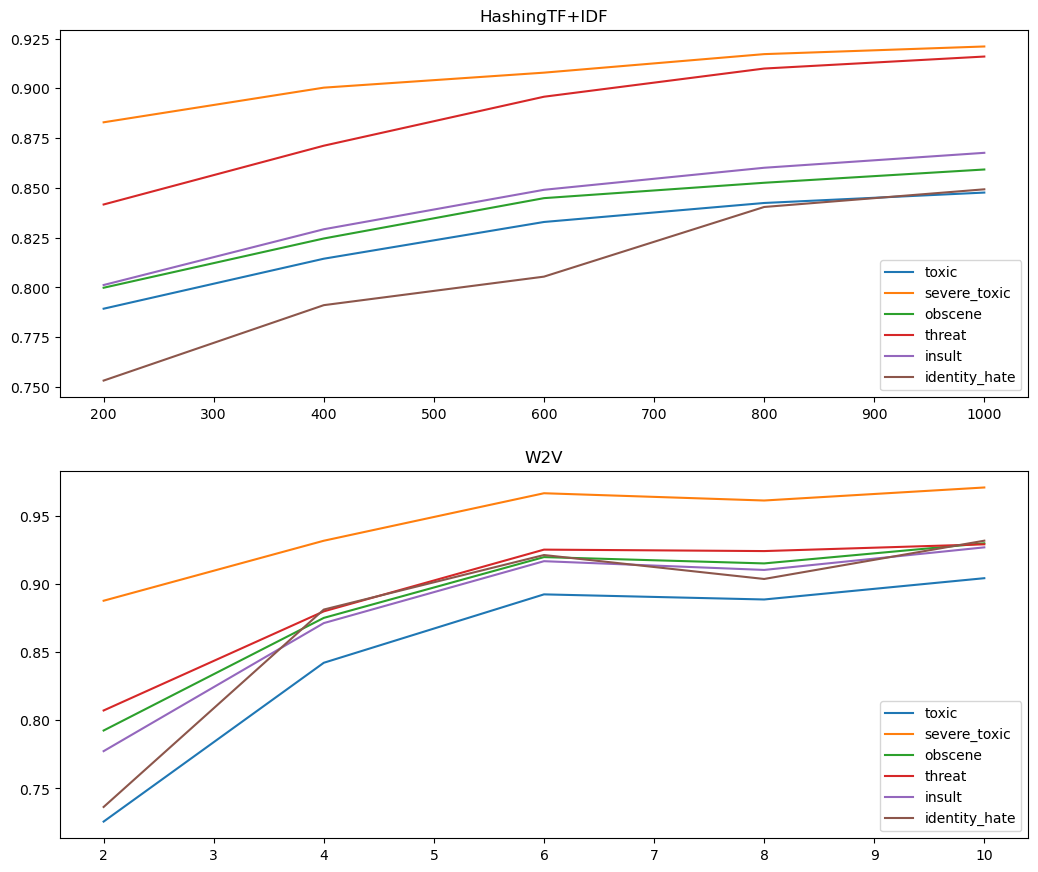

In [34]:
fig, axs = plt.subplots(2)
fig.set_size_inches(12.5, 10.5)
lines_x = {}
lines_y = {}
for res in res_idf:
    if res[1] not in lines_x:
        lines_x[res[1]] = [res[0]]
        lines_y[res[1]] = [res[2]]
    else:
        lines_x[res[1]].append(res[0])
        lines_y[res[1]].append(res[2])
   
for cat in  lines_x:
    
    axs[0].plot(lines_x[cat], lines_y[cat], label=cat)
    axs[0].legend()
    axs[0].set_title('HashingTF+IDF')
    
    
lines_x = {}
lines_y = {}
for res in res_w2v:
    if res[1] not in lines_x:
        lines_x[res[1]]= [res[0]]
        lines_y[res[1]]= [res[2]]
    else:
        lines_x[res[1]].append(res[0])
        lines_y[res[1]].append(res[2])
    
for cat in  lines_x:
    
    axs[1].plot(lines_x[cat], lines_y[cat], label=cat)
    axs[1].legend()
    axs[1].set_title('W2V')
  
plt.show() 